# Ranking with text and links

# Dataset: Enron Email Dataset

Enron Email Dataset - (https://www.cs.cmu.edu/~enron/).

Below is an example of one email.

```text
Message-ID: <33025919.1075857594206.JavaMail.evans@thyme>
Date: Wed, 13 Dec 2000 13:09:00 -0800 (PST)
From: john.arnold@enron.com
To: slafontaine@globalp.com
Subject: re:spreads
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: John Arnold
X-To: slafontaine@globalp.com @ ENRON
X-cc:
X-bcc:
X-Folder: \John_Arnold_Dec2000\Notes Folders\'sent mail
X-Origin: Arnold-J
X-FileName: Jarnold.nsf

saw a lot of the bulls sell summer against length in front to mitigate
margins/absolute position limits/var.  as these guys are taking off the
front, they are also buying back summer.  el paso large buyer of next winter
today taking off spreads.  certainly a reason why the spreads were so strong
on the way up and such a piece now.   really the only one left with any risk
premium built in is h/j now.   it was trading equivalent of 180 on access,
down 40+ from this morning.  certainly if we are entering a period of bearish
to neutral trade, h/j will get whacked.  certainly understand the arguments
for h/j.  if h settles $20, that spread is probably worth $10.  H 20 call was
trading for 55 on monday.  today it was 10/17.  the market's view of
probability of h going crazy has certainly changed in past 48 hours and that
has to be reflected in h/j.




slafontaine@globalp.com on 12/13/2000 04:15:51 PM
To: slafontaine@globalp.com
cc: John.Arnold@enron.com
Subject: re:spreads



mkt getting a little more bearish the back of winter i think-if we get another
cold blast jan/feb mite move out. with oil moving down and march closer flat
px
wide to jan im not so bearish these sprds now-less bullish march april as
well.
```

# Part 1: Parse the Email Data to Build a Graph (50 points)

---

Recall how we parse the email content in HW1. Now, in this part, we're going to parse the dataset to build a graph. So, instead of viewing the world as web pages with hyperlinks (where pages = nodes, hyperlinks = edges), we view it as users in an email network. Over this graph, we can apply classic methods like PageRank and Hubs-and-Authorities to order the users according to some notion of importance.

For the first part, you will complete the following code to construct the graph based on the given data. In this graph, the node is the user and a link between two users is added if user A sent an email to user B. The weight of the link is the number of emails sent between user A and user B.

You will need to write a python code to loop through each email file and extract the sender and receiver of each email.
Specifically, you should extract the sender from the `From: john.arnold@enron.com` and receiver from the `To: slafontaine@globalp.com` fields at the top of each email.

* Use the email address to represent a unique user.
* Remove any space in the email. User lower case for the email address.
* Only extract the email addresses that are in the `From:` and `To:` fields at the top of the email. If the email contains forwarded emails below, you can ignore them.
* Choose a proper data structure to store the unique users and the number of times they appear in the dataset. We will use it to build a graph later.

### Print the number of total emails

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
# import zipfile

dirpath = "/content/drive/MyDrive/ML_633/enron_sent_mail.zip"
extract_path = "/content/drive/MyDrive/ML_633/enron"

# with zipfile.ZipFile(dirpath, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

path = extract_path +"/enron_sent_mail"

files = []
for dir in os.listdir(path):
    dir_path = os.path.join(path, dir, "_sent_mail")
    if os.path.isdir(dir_path):
      for file in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file)
        if os.path.isfile(file_path):
          with open(file_path, 'r') as f:
              outfile = f.read()
              files.append(outfile)

# print(files[0])

In [4]:
print("Total files:", len(files))
filtered_files = []
for file in files:
  lines = file.split("\n")
  found_from = False
  found_to = False

  for line in lines:
    if line.startswith("X-"):
      break
    if line.lower().startswith("from:"):
      found_from = True
    elif line.lower().startswith("to:"):
      found_to = True
    if found_from and found_to:
      filtered_files.append(file)
      break

print("Valid emails:", len(filtered_files))

Total files: 30109
Valid emails: 30034


In [5]:
from collections import defaultdict
import re

def extract_mails(file):
  lines = file.split("\n")
  from_email = ""
  to_email = set()
  collecting_to = False # to track multiple line for to_emails
  numlist = defaultdict(lambda: [0, 0])

  for line in lines:
    line = line.strip()
    if line.startswith("X-"):
      break

    if not from_email and line.lower().startswith("from:"):
      from_email = line.split(":", 1)[1].strip().lower()
      numlist[from_email][0] += 1

    elif line.lower().startswith("to:"):
      collecting_to = True  # collecting 'To:' emails
      to_email.update({email.strip() for email in line.split(":", 1)[1].split(",") if email.strip()})

    elif collecting_to:
      if ":" not in line:
        to_email.update({email.strip().lower() for email in line.split(",") if email.strip()})
      else:
        collecting_to = False

    if not collecting_to and to_email and from_email:
      for email in to_email:
        numlist[email][1] += 1
      break

  return from_email, to_email, dict(numlist)

email_edges = defaultdict(lambda: defaultdict(int))

mail_collect = defaultdict(lambda: [0, 0])
for file in filtered_files:
    from_email, to_email, counts_data = extract_mails(file)
    for email, num in counts_data.items():
      mail_collect[email][0] += num[0]
      mail_collect[email][1] += num[1]
    if from_email and to_email:
      for to in to_email:
        email_edges[from_email][to] += 1

### Print the number of unique users

In [ ]:

unique_mails = set()
unique_mails.update(email_edges.keys())

for rec in email_edges.values():
    unique_mails.update(rec.keys())

print("Unique Emails:", len(unique_mails))

Unique Emails: 7008


### Print the top-5 users ranked by the number of emails they involved in the dataset

In [ ]:

# from_email->to_email->count
total_emails = {}
for user, num in mail_collect.items():
  total_emails[user] = num[0] + num[1]

email_list = [(user, count) for user, count in total_emails.items()]

sorted_email_list = sorted(email_list, key=lambda x: x[1], reverse=True)
top_5_users = sorted_email_list[:5]
print("user\t\temails_involved")
for user, count in top_5_users:
    print(f"{user}\t{count}")


user		emails_involved
kay.mann@enron.com	4231
vince.kaminski@enron.com	3518
chris.germany@enron.com	1695
eric.bass@enron.com	1453
kate.symes@enron.com	1340


### Print the top-5 users who sent out the most emails in the dataset

Note that here, we only consider the person who sent the email, not the receiver.

In [ ]:

emails_from = {}
for user, num in mail_collect.items():
  emails_from[user] = num[0]

email_list_senders = [(user, count) for user, count in emails_from.items()]
sorted_emails_from = sorted(email_list_senders, key=lambda x: x[1], reverse=True)
top_5_sent = sorted_emails_from[:5]
print("user\t\temails_sent")
for user, count in top_5_sent:
    print(f"{user}\t{count}")

user		emails_sent
kay.mann@enron.com	4220
vince.kaminski@enron.com	3455
chris.germany@enron.com	1658
eric.bass@enron.com	1409
kate.symes@enron.com	1322


### Print the top-5 users who received the most emails in the dataset

Note that here, we only consider the receiver, not sender.

In [ ]:

emails_to = {}
for user, num in mail_collect.items():
  emails_to[user] = num[1]

email_list_receive = [(user, count) for user, count in emails_to.items()]
sorted_emails_to = sorted(email_list_receive, key=lambda x: x[1], reverse=True)
top_5_to = sorted_emails_to[:5]
print("user\t\temails_received")
for user, count in top_5_to:
    print(f"{user}\t{count}")

user		emails_received
vkaminski@aol.com	1061
suzanne.adams@enron.com	428
shirley.crenshaw@enron.com	304
nmann@erac.com	285
john.lavorato@enron.com	272


### Let's build the graph!

Here we are going to use the `networkx` library to build the graph. You can install the library by running `!pip install networkx`.

We are going to build an `undirected` graph (regardless of who sent to whom). The nodes of the graph are the users (represented by the unique email address) and the edges are the emails sent between the users. The weight of the edge is the number of emails sent between the users.

For example, if user A sent 3 emails to user B, and user B sent 2 emails to user A, then the weight of the edge between A and B is 3+2=5.

In [29]:
!pip install networkx

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

In [ ]:
G = nx.Graph()

unique_mails = list(unique_mails)
for user in unique_mails:
    G.add_node(user)

for user in tqdm(range(len(unique_mails)), desc="Processing users"):
  for i in range(user+1, len(unique_mails)):  # Ensure no duplicate edges
    send = unique_mails[user]
    rec = unique_mails[i]
    weight = email_edges.get(send, {}).get(rec, 0) + email_edges.get(rec, {}).get(send, 0)
    if weight > 0:
      if G.has_edge(send, rec):
          G[send][rec]['weight'] += weight
      else:
          G.add_edge(send, rec, weight=weight)

edges_with_weights = list(G.edges(data=True))

Processing users: 100%|██████████| 7008/7008 [00:14<00:00, 498.59it/s] 


### Visualization of the graph

Now you have built the graph. Let's visualize the graph. Use any package you like to visualize the graph.

You can find some examples here: https://networkx.org/documentation/stable/auto_examples/index.html

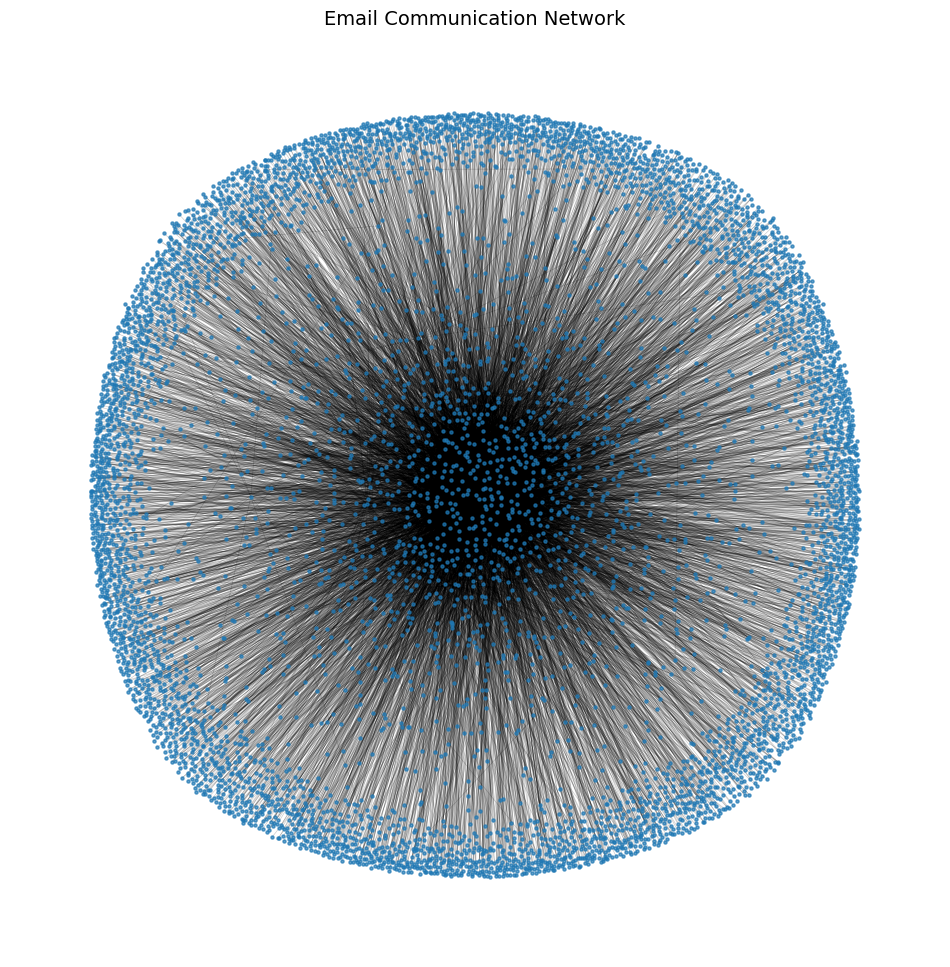

In [13]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.3, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=5, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

plt.axis("off")
plt.title("Email Communication Network", fontsize=14)
plt.show()

Top 3 nodes with highest degree:
Node: sally.beck@enron.com, Degree: 903
Node: vince.kaminski@enron.com, Degree: 762
Node: mary.hain@enron.com, Degree: 525

No isolated nodes found.


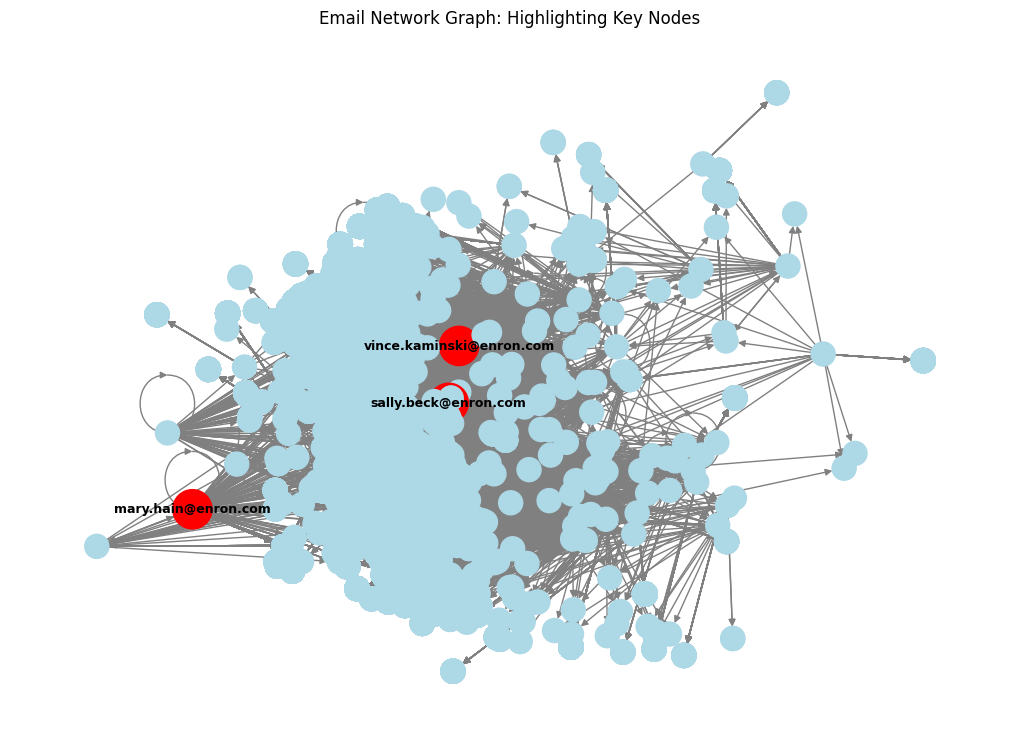

In [14]:
import networkx as nx
import matplotlib.pyplot as plt


G1 = nx.DiGraph(email_edges)
degree_dict = dict(G1.degree())
sorted_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)

# Identify key nodes
top_nodes = sorted_nodes[:3]  # Top 3 most connected nodes
isolated_nodes = list(nx.isolates(G1))  # Nodes with no connections

print("Top 3 nodes with highest degree:")
for node in top_nodes:
  print(f"Node: {node}, Degree: {degree_dict[node]}")

if isolated_nodes:
  print("\nIsolated nodes:")
  for node in isolated_nodes:
    print(f"Node: {node}, Degree: 0")
else:
  print("\nNo isolated nodes found.")

# Node size scaling
node_sizes = [800 if node in top_nodes else (400 if node in isolated_nodes else 300) for node in G1.nodes()]

# Node color
node_colors = [
    'red' if node in top_nodes else ('gray' if node in isolated_nodes else 'lightblue') for node in G1.nodes()]

labels = {node: node if node in top_nodes or node in isolated_nodes else "" for node in G1.nodes()}

pos = nx.kamada_kawai_layout(G1)  # Alternative layout for better clarity

plt.figure(figsize=(10, 7))
nx.draw(G1, pos, with_labels=True, labels=labels, node_size=node_sizes, node_color=node_colors, edge_color='gray', font_size=9, font_weight='bold')
plt.title("Email Network Graph: Highlighting Key Nodes", fontsize=12)
plt.show()

### Observation of the graph

```text
* Observation 1: Yes, based on the results, we can conclude that sally.beck@enron.com has the most connections, with a degree of 903, placing it at the center of the graph. This indicates that this user is highly influential and central to the network.
* Observation 2: From the graph, there are no isolated users. This likely results from the fact that we removed files that did not contain either 'From' or 'To' fields, ensuring that every email is somehow connected to others. Therefore, all nodes in the graph have at least one connection.
* Observation 3: The top 3 nodes with the highest degree are displayed in red color and have a larger size to make them stand out from the others.
These are:
  sally.beck@enron.com with a degree of 903 (most connected),
  vince.kaminski@enron.com with a degree of 762,
  mary.hain@enron.com with a degree of 525.
These top nodes are the most influential users in the network, as they have the highest connectivity.
```

# Part 2: Link-based Ranking

### A: PageRank
Print the top-5 highest PageRank scores in `user: score` format.

In [ ]:

page_rank_scores = nx.pagerank(G)

users_by_pagerank_sorted = sorted(page_rank_scores.items(), key=lambda x: x[1], reverse=True)
print("Top 5 email users by PageRank:")
for user, score in users_by_pagerank_sorted[:5]:
    print(f"{user}: {score}")

Top 5 email users by PageRank:
vince.kaminski@enron.com: 0.03948482816296768
kay.mann@enron.com: 0.029069656332330357
sally.beck@enron.com: 0.028298295160159737
jeff.skilling@enron.com: 0.027908163756745447
mary.hain@enron.com: 0.024377384265101616


### B: Personalized PageRank

In [ ]:

personalized_page_rank = nx.pagerank(G, personalization={"john.arnold@enron.com": 1})
personalized_page_rank_sorted = sorted(personalized_page_rank.items(), key=lambda x: x[1], reverse=True)
for user, score in personalized_page_rank_sorted [:5]:
    print(f"{user}: {score}")

john.arnold@enron.com: 0.2555961270934766
john.lavorato@enron.com: 0.024948069707445335
vince.kaminski@enron.com: 0.023958077572700465
sally.beck@enron.com: 0.017387467792814634
kay.chapman@enron.com: 0.01650142051390743


# **Samples for Discussion:**

In [17]:
# Here, i will consider two more users along with John.arnold@enron.com - sally.beck@enron.com and michele.beffer@enron.com
# 1. user of interest is sally.beck@enron.com
# 2. user of interest is michele.beffer@enron.com
# 3. Bias towards user michele than sally - {0.8, 02}
# 4. Bias towards user sally than michele - {0.2, 0.8}
# 5. More bias towards michele and sally than John.arnold- {0.4, 0.4, 0.2}

personalized_page_rank1 = nx.pagerank(G, personalization={"sally.beck@enron.com": 1})
personalized_page_rank_sorted1 = sorted(personalized_page_rank1.items(), key=lambda x: x[1], reverse=True)
for user, score in personalized_page_rank_sorted1 [:5]:
    print(f"{user}: {score}")


sally.beck@enron.com: 0.26452059522482185
chris.germany@enron.com: 0.03436625763191205
patti.thompson@enron.com: 0.02317503144237867
vince.kaminski@enron.com: 0.017475892760837393
eric.bass@enron.com: 0.0164215458592058


In [18]:
personalized_page_rank2 = nx.pagerank(G, personalization={"michele.beffer@enron.com": 1})
personalized_page_rank_sorted2 = sorted(personalized_page_rank2.items(), key=lambda x: x[1], reverse=True)
for user, score in personalized_page_rank_sorted2 [:5]:
    print(f"{user}: {score}")

sally.beck@enron.com: 0.2247370179884393
michele.beffer@enron.com: 0.15012807388131363
chris.germany@enron.com: 0.028967975994694476
patti.thompson@enron.com: 0.019684844668129434
vince.kaminski@enron.com: 0.014607488356534679


In [19]:
personalized_page_rank3 = nx.pagerank(G, personalization={"michele.beffer@enron.com": 0.2, "sally.beck@enron.com":0.8})
personalized_page_rank_sorted3 = sorted(personalized_page_rank3.items(), key=lambda x: x[1], reverse=True)
for user, score in personalized_page_rank_sorted3 [:5]:
    print(f"{user}: {score}")

sally.beck@enron.com: 0.25658161510541627
chris.germany@enron.com: 0.033325013946746904
michele.beffer@enron.com: 0.030146114278892695
patti.thompson@enron.com: 0.022479233050821206
vince.kaminski@enron.com: 0.016954144112643656


In [20]:
personalized_page_rank4 = nx.pagerank(G, personalization={"michele.beffer@enron.com": 0.8, "sally.beck@enron.com":0.2})
personalized_page_rank_sorted4 = sorted(personalized_page_rank4.items(), key=lambda x: x[1], reverse=True)
for user, score in personalized_page_rank_sorted4 [:5]:
    print(f"{user}: {score}")

sally.beck@enron.com: 0.23276467474719617
michele.beffer@enron.com: 0.12013255393766396
chris.germany@enron.com: 0.030201282891251343
patti.thompson@enron.com: 0.02039183787614876
vince.kaminski@enron.com: 0.01538889816806245


In [21]:
personalized_page_rank5 = nx.pagerank(G, personalization={"michele.beffer@enron.com": 0.4, "sally.beck@enron.com":0.4, "john.arnold@enron.com":0.2})
personalized_page_rank_sorted5 = sorted(personalized_page_rank5.items(), key=lambda x: x[1], reverse=True)
for user, score in personalized_page_rank_sorted5 [:5]:
    print(f"{user}: {score}")

sally.beck@enron.com: 0.19921600949960783
michele.beffer@enron.com: 0.06011343728953284
john.arnold@enron.com: 0.05502294927022172
chris.germany@enron.com: 0.027917575191425435
patti.thompson@enron.com: 0.017760655185061598


### C: Hubs and Authorities

In [ ]:
import numpy as np
hub_values = {user: 1 for user in G.nodes()}
authority_values = {user: 1 for user in G.nodes()}

repetitions = 12

for i in range(repetitions):
    authority_values_n = {}
    for user in G.nodes():
        authority_score_n = sum(hub_values[n] * G[user][n]['weight'] for n in G[user])
        authority_values_n[user] = authority_score_n

    hub_values_n = {}
    for user in G.nodes():
        hub_score_n = sum(authority_values[n] * G[user][n]['weight'] for n in G[user])
        hub_values_n[user] = hub_score_n

    norm_value = np.sqrt(sum(score**2 for score in hub_values_n.values()))
    hub_values = {user: score/norm_value for user, score in hub_values_n.items()}

    norm_value1 = np.sqrt(sum(score**2 for score in authority_values_n.values()))
    authority_values = {user: score/norm_value1 for user, score in authority_values_n.items()}

hubs_values_sorted = sorted(hub_values.items(), key=lambda x: x[1], reverse=True)[:5]
authorities_values_sorted = sorted(authority_values.items(), key=lambda x: x[1], reverse=True)[:5]

print("Hub Scores")
for user, score in hubs_values_sorted:
    print(f"{user}: {score}")

print("\nAuthority Scores")
for user, score in authorities_values_sorted:
    print(f"{user}: {score}")

Hub Scores
vkaminski@aol.com: 0.8991323470357485
vince.kaminski@enron.com: 0.30379127520219845
shirley.crenshaw@enron.com: 0.2567809322890518
stinson.gibner@enron.com: 0.10086252331801919
mike.roberts@enron.com: 0.04662146828325384

Authority Scores
vkaminski@aol.com: 0.8991323470357485
vince.kaminski@enron.com: 0.30379127520219845
shirley.crenshaw@enron.com: 0.2567809322890518
stinson.gibner@enron.com: 0.10086252331801919
mike.roberts@enron.com: 0.04662146828325384


### Discussion

**Page Rank:**

*  Evaluates a webpage's significance by analyzing both the quantity and quality of incoming links.
*  Assumes that pages with more and higher-quality links hold greater importance. PageRank assigns a score to each page based on its inbound links and the authority of the linking pages.
*  Goal is to measure a page's overall influence within the broader web network. It is effective in identifying influential nodes in a network.

**Personalized Page Rank:**

*  An extension of PageRank that tailors rankings based on user preferences. Useful for delivering context-specific search results.
*  Rather than assessing a page's overall importance, it prioritizes its relevance to a specific user's interests.
*  It factors in both the web's structure and the user's browsing history or stated preferences to generate personalized rankings.

**Hubs & Authorities:**

*   Designed to identify valuable resources on specific topics.
*   Based on the principle that authoritative pages link to relevant content, and vice versa. It assigns scores to hubs (pages with many outbound links to related content) and authorities (pages with numerous inbound links from hubs).
*   Also highlights high-quality content and trustworthy sources within a given topic.






**Findings in Personalized PageRank:**

# 1. user of interest is John.arnold@enron.com
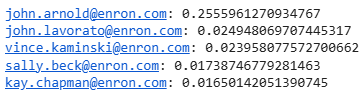
# 2. user of interest is sally.beck@enron.com
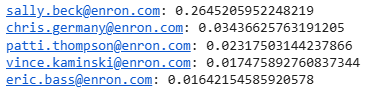
# 3. user of interest is michele.beffer@enron.com
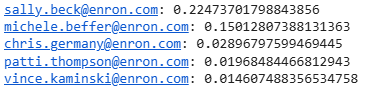
# 4. Bias towards user michele than sally - {0.8, 02}
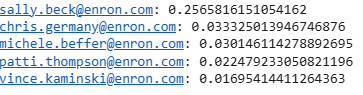
# 5. Bias towards user sally than michele - {0.2, 0.8}
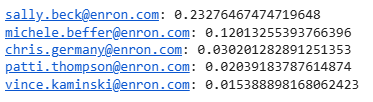
# 6. More bias towards michele and sally than John.arnold- {0.4, 0.4, 0.2}
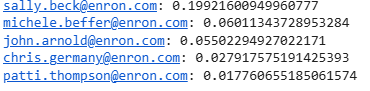

From the above tests, we observe that adjusting probability values significantly impacts both scores and rankings. For instance, in cases 1 and 2, John was ranked first when he was the person of interest. However, when Sally became the focal point, John didn't even appear in the top five. Similarly, in cases 2 and 3, despite Michelle being the person of interest in 3, Sally still ranked first due to Michelle having very few connections or links.

One key takeaway is that a higher probability leads to a higher ranking. If we consider only Michelle and John with equal probability, John would secure the top rank. However, in case 5, where John was given less weight, Michelle ranked higher than him.